In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium # for map rendering
from geopy.geocoders import Nominatim
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
toronto_data = pd.read_csv("toronto_postcodes_v3.csv")
toronto_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [3]:
toronto_data['Borough'].unique().shape

(11,)

In [4]:
toronto_data['Borough'].unique()

array(['North York', 'Downtown Toronto', "Queen's Park", 'Etobicoke',
       'Scarborough', 'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [5]:
toronto_data['Borough'].value_counts()

North York          24
Downtown Toronto    18
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
East York            5
York                 5
Mississauga          1
Queen's Park         1
Name: Borough, dtype: int64

<h5>Let's get the geographical coordinates of Toronto city using geopy library</h5>

In [6]:
address = 'Toronto'
geolocator = Nominatim(user_agent="tnt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


<h5>Visualization of areas on the map using folium library</h5>
    <p>We are using postal code areas in our analysis, because some postal code areas have multiple neighbourhoods. When we visualize neighbourhoods on the map, it can be confusing. Postal codes represent neighbours or group of neighbours. That means we will cluster these postal codes which have only one borough. </p>

In [7]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, borough, postcode in zip(toronto_data['Latitude'], toronto_data['Longitude'], 
                                       toronto_data['Borough'], toronto_data['PostalCode']):
    label = '{}, {}'.format(postcode, borough)
    label = folium.Popup(label, parse_html=True)
    tip = 'PostalCode'
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#5199FF',
        fill=True,
        fill_color='#B7D4FF',
        fill_opacity=0.6,
        parse_html=True
        ).add_to(map_toronto)  
    
map_toronto

<h5>Decreasing data for the sake of simplicity</h5>
<p>Let's simplify the above map and segment and cluster only the posctcodal areas in the boroughs boroughs that contain the word 'Toronto'.</p>

In [8]:
tor_df = toronto_data.loc[toronto_data['Borough'].str.contains('Toronto')].reset_index(drop=True)
tor_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [9]:
map_tor = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, borough, postcode in zip(tor_df['Latitude'], tor_df['Longitude'], 
                                       tor_df['Borough'], tor_df['PostalCode']):
    label = '{}, {}'.format(postcode, borough)
    label = folium.Popup(label, parse_html=True)
    tip = 'PostalCode'
    
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='#F6C324',
        fill=True,
        fill_color='#0067B3',
        fill_opacity=0.6,
        parse_html=True
        ).add_to(map_tor)  
    
map_tor

In [10]:
tor_df['Borough'].value_counts()

Downtown Toronto    18
Central Toronto      9
West Toronto         6
East Toronto         5
Name: Borough, dtype: int64

<h5>Analysis of first postal code area(neighbourhood)</h5>

First postal code area info:

In [11]:
tor_df.iloc[0,:]

PostalCode                             M5A
Borough                   Downtown Toronto
Neighbourhood    Harbourfront, Regent Park
Latitude                           43.6543
Longitude                         -79.3606
Name: 0, dtype: object

In [12]:
first_lat = tor_df.loc[0, 'Latitude']
first_long = tor_df.loc[0, 'Longitude']
first_code = tor_df.loc[0, 'PostalCode']
print('Latitude and longitude values of postalCode {} are {}, {}.'.format(first_code, first_lat, first_long))

Latitude and longitude values of postalCode M5A are 43.6542599, -79.3606359.


<h5>Now, let's get the top 100 venues that are in M5A postal code area within a radius of 500 meters.</h5> 

First definition Foursquare Credentials and version

In [13]:
CLIENT_ID = 'KVZ4QIDBPQZZMNM5HUD4UHZEX3IQ3FIQM5P2URZQIBC2AZ5H' 
CLIENT_SECRET = '35401EZGW344DHZMX42QCF4V0MSROH104WL3UZSE2G4W4DML' 
VERSION = '20180605'

Now, creation of the GET request URL.

In [14]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    first_lat, 
    first_long, 
    radius, 
    LIMIT)

Sending the GET request, and getting the response

In [15]:
response = requests.get(url).json()
print("There are total {} venue nearby M5A area.".format(response['response']['totalResults']))

There are total 49 venue nearby M5A area.


I implement this function from Newyor city analysis notebook

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = response['response']['groups'][0]['items'] # that returns the venues as list 
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Toronto Cooper Koo Family Cherry St YMCA Centre,Gym / Fitness Center,43.653191,-79.357947
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149


How many venue are there in each category?

In [18]:
nearby_venues['categories'].value_counts()

Coffee Shop              8
Park                     3
Pub                      3
Bakery                   3
Theater                  2
Restaurant               2
Breakfast Spot           2
Mexican Restaurant       2
Gym / Fitness Center     2
Café                     2
Bank                     1
French Restaurant        1
Event Space              1
Chocolate Shop           1
Brewery                  1
Health Food Store        1
Beer Store               1
Historic Site            1
Farmers Market           1
Antique Shop             1
Electronics Store        1
Cosmetics Shop           1
Dessert Shop             1
Shoe Store               1
Italian Restaurant       1
Hotel                    1
Spa                      1
Art Gallery              1
Performing Arts Venue    1
Ice Cream Shop           1
Name: categories, dtype: int64

We can visualize top 10 venues with pie chart.

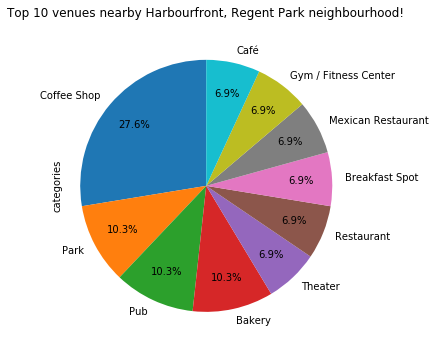

In [19]:
nearby_venues['categories'].value_counts()[:10].plot(kind='pie', 
                                                     figsize=(5, 6),
                                                     startangle=90, 
                                                     autopct='%1.1f%%',
                                                     pctdistance=0.75)
plt.title('Top 10 venues nearby Harbourfront, Regent Park neighbourhood!')
plt.axis('equal')
plt.show()

<h2>Exploration neighbourshoods that contains 'Toronto' word</h2>

In [20]:
tor_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


Implementing the function from Newyork City notebook to repeat the same process to all the neighborhoods in our dataframe. 

In [21]:
def getNearbyVenues(codes, neighbourhoods, latitudes, longitudes, rad=500, limit=100):
    venues_list=[]
    for code, neigh, lat, lng in zip(codes, neighbourhoods, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            limit)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            code,
            neigh,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode Area', 
                             'Neighbourhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

We are calling the function above in order to create venues dataframe.

In [22]:
toronto_venues = getNearbyVenues(tor_df['PostalCode'], 
                                 tor_df['Neighbourhood'], 
                                 tor_df['Latitude'], 
                                 tor_df['Longitude'],rad=500, 
                                 limit=100)

In [23]:
print(toronto_venues.shape)
toronto_venues.head()

(1728, 8)


,PostalCode Area,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,"Harbourfront, Regent Park",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,"Harbourfront, Regent Park",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,"Harbourfront, Regent Park",43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,M5A,"Harbourfront, Regent Park",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,"Harbourfront, Regent Park",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


How many venues were returned for each postal code area?

In [24]:
toronto_venues.groupby('PostalCode Area')['Venue'].count()

PostalCode Area
M4E      5
M4K     41
M4L     23
M4M     41
M4N      4
M4P     10
M4R     19
M4S     32
M4T      2
M4V     15
M4W      5
M4X     45
M4Y     88
M5A     49
M5B    100
M5C    100
M5E     57
M5G     89
M5H    100
M5J    100
M5K    100
M5L    100
M5N      2
M5P      5
M5R     23
M5S     35
M5T    100
M5V     16
M5W     97
M5X    100
M6G     16
M6H     21
M6J     64
M6K     27
M6P     23
M6R     15
M6S     40
M7Y     19
Name: Venue, dtype: int64

 How many unique categories are there in the returned venues?

In [25]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 239 uniques categories.


<h2>3. Analyze Each PostalCode Area</h2>

In [26]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['PostalCode'] = toronto_venues['PostalCode Area'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
toronto_onehot.shape

(1728, 240)

In [28]:
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
toronto_grouped.head()

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,M4E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.20000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,M4K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02439,...,0.0,0.02439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02439
2,M4L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,M4M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04878,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02439
4,M4N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


In [29]:
toronto_grouped.shape

(38, 240)

We are implementing the function to get common venues.

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now, we will create a new dataframe and display the top 20 venues for each postal code area.

In [31]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postalcode_venues_sorted = pd.DataFrame(columns=columns)
postalcode_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    postalcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

postalcode_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,M4E,Pub,Other Great Outdoors,Trail,Neighborhood,Health Food Store,Event Space,Ethiopian Restaurant,Electronics Store,Falafel Restaurant,...,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Dive Bar,Discount Store,Yoga Studio,Dessert Shop,Dim Sum Restaurant
1,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Ice Cream Shop,Spa,Bookstore,Brewery,Bubble Tea Shop,...,Caribbean Restaurant,Pub,Cosmetics Shop,Grocery Store,Bakery,Dessert Shop,Diner,Liquor Store,Juice Bar,Fruit & Vegetable Store
2,M4L,Park,Sandwich Place,Brewery,Sushi Restaurant,Steakhouse,Food & Drink Shop,Fish & Chips Shop,Fast Food Restaurant,Board Shop,...,Intersection,Burrito Place,Movie Theater,Pub,Pizza Place,Pet Store,Italian Restaurant,Liquor Store,Ice Cream Shop,Gym
3,M4M,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Gastropub,Yoga Studio,Chinese Restaurant,Fish Market,...,Brewery,Seafood Restaurant,Sandwich Place,Cheese Shop,Clothing Store,Middle Eastern Restaurant,Stationery Store,Diner,Music Store,Comfort Food Restaurant
4,M4N,Gym / Fitness Center,Park,Swim School,Bus Line,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,...,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Dive Bar,Dim Sum Restaurant,Diner,Fast Food Restaurant,Dessert Shop


<h2>4. Cluster PostalCode Areas (Neighbourhoods)</h2>

We will use k-mean clustering to cluster postal code areas into 4 cluster.

In [32]:
# import K-Means 
from sklearn.cluster import KMeans

# set number of clusters
k = 5

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 4, 1, 1, 1, 3, 1])

Now, we will create a new dataframe that includes the cluster as well as the top 20 venues for each postal code area.

In [33]:
# add clustering labels
postalcode_venues_sorted.insert(0, column='Cluster Labels', value=kmeans.labels_)
postalcode_venues_sorted.head()

,Cluster Labels,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,0,M4E,Pub,Other Great Outdoors,Trail,Neighborhood,Health Food Store,Event Space,Ethiopian Restaurant,Electronics Store,...,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Dive Bar,Discount Store,Yoga Studio,Dessert Shop,Dim Sum Restaurant
1,1,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Ice Cream Shop,Spa,Bookstore,Brewery,...,Caribbean Restaurant,Pub,Cosmetics Shop,Grocery Store,Bakery,Dessert Shop,Diner,Liquor Store,Juice Bar,Fruit & Vegetable Store
2,1,M4L,Park,Sandwich Place,Brewery,Sushi Restaurant,Steakhouse,Food & Drink Shop,Fish & Chips Shop,Fast Food Restaurant,...,Intersection,Burrito Place,Movie Theater,Pub,Pizza Place,Pet Store,Italian Restaurant,Liquor Store,Ice Cream Shop,Gym
3,1,M4M,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Gastropub,Yoga Studio,Chinese Restaurant,...,Brewery,Seafood Restaurant,Sandwich Place,Cheese Shop,Clothing Store,Middle Eastern Restaurant,Stationery Store,Diner,Music Store,Comfort Food Restaurant
4,4,M4N,Gym / Fitness Center,Park,Swim School,Bus Line,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,...,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Dive Bar,Dim Sum Restaurant,Diner,Fast Food Restaurant,Dessert Shop


In [34]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = pd.merge(tor_df, postalcode_venues_sorted, on='PostalCode', how='inner')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,1,Coffee Shop,Bakery,Park,Pub,...,Chocolate Shop,Dessert Shop,French Restaurant,Performing Arts Venue,Electronics Store,Event Space,Farmers Market,Shoe Store,Brewery,Spa
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Cosmetics Shop,Middle Eastern Restaurant,...,Tea Room,Bubble Tea Shop,Theater,Pizza Place,Diner,Lingerie Store,Japanese Restaurant,Restaurant,Movie Theater,Beer Bar
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Restaurant,Hotel,...,Farmers Market,Diner,Cheese Shop,Creperie,Beer Bar,Clothing Store,Japanese Restaurant,Park,Seafood Restaurant,Cocktail Bar
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Other Great Outdoors,Trail,Neighborhood,...,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Dive Bar,Discount Store,Yoga Studio,Dessert Shop,Dim Sum Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Bakery,Cocktail Bar,Farmers Market,...,Belgian Restaurant,Bistro,Jazz Club,Fish Market,Breakfast Spot,Liquor Store,Restaurant,Basketball Stadium,Lounge,Eastern European Restaurant


Finally, visualizing the resulting clusters

In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters